In [1]:
#datacollection and cleaning
import requests
from bs4 import BeautifulSoup as Soup
import pandas as pd
import os
from datetime import datetime, timedelta
locations = ["Mumbai", "New Delhi", "Bangalore", "Kolkata", "Chennai", "Hyderabad", "Ahmedabad", "Pune", "Surat", "Jaipur", "Lucknow", "Kanpur", "Nagpur", "Indore", "Thane", "Bhopal", "Visakhapatnam", "Pimpri-Chinchwad", "Patna", "Vadodara"]
# Function to scrape data from Booking.com
def scrape_bookingdotcom(destination, checkin_date, checkout_date):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'
    }
    req = requests.get(
        f"https://www.booking.com/searchresults.en-gb.html?ss={destination}&checkin={checkin_date}&checkout={checkout_date}&offset==0",
        headers=headers).text
    soup = Soup(req, 'html.parser')
    ap = soup.find("ol", {"class": "a8b500abde"}).text

    df = pd.DataFrame(columns=["price", "location", "distance", "amenities", "ratings", "type"])
    for pages in range(0, int(ap[len(ap) - 1])):
        req = requests.get(
            f"https://www.booking.com/searchresults.en-gb.html?ss={destination}&checkin={checkin_date}&checkout={checkout_date}&offset=={pages * 25}",
            headers=headers).text
        soup = Soup(req, 'html.parser')
        apts = soup.find_all("div", {"class": "d20f4628d0"})
        rows = []

        for a in range(0, len(apts)):
            obj = {}

            try:
                obj["price"] = apts[a].find("span", {"class": "fcab3ed991 fbd1d3018c e729ed5ab6"}).text
            except:
                obj["price"] = None

            try:
                obj["distance"] = apts[a].find("span", {"class": "cb5ebe3ffb"}).text
            except:
                obj["distance"] = None

            try:
                ap1 = apts[a].find('a', href=True)
                link = ap1['href']
                req1 = requests.get(link, headers=headers).text
                soup2 = Soup(req1, 'html.parser')
                obj["amenities"] = soup2.find("div", {"class": "e5e0727360"}).text
            except:
                obj["amenities"] = None

            try:
                obj["ratings"] = apts[a].find("div", {"class": "b5cd09854e d10a6220b4"}).text
            except:
                obj["ratings"] = None

            try:
                obj["type"] = apts[a].find("span", {"class": "df597226dd"}).text
            except:
                obj["type"] = None

            try:
                obj["location"] = apts[a].find("span", {"class": "f4bd0794db b4273d69aa"}).text
            except:
                obj["location"] = None

            rows.append(obj)

        df = pd.concat([df, pd.DataFrame(rows)])

    # Data cleaning
    df["price"] = df["price"].str.replace(r"₹", "")
    df["price"] = df["price"].str.replace(r" ", "")
    df["price"] = df["price"].str.replace(r",", "")
    df["price"] = df["price"].str.strip()
    df['price'] = pd.to_numeric(df['price'])
    df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce')
    df['ratings'] = df['ratings'].fillna(df['ratings'].mean())

    return df


# Take user input for the location, check-in date, and check-out date
user_location = input("Enter the city name: ").strip().capitalize()
current_date = datetime.now().strftime("%Y-%m-%d")
checkin_date = current_date
checkout_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
scraped_locations=[]
# Check if location has already been scraped
csv_filename = (f"{user_location}_{current_date}.csv")
if os.path.isfile(csv_filename):
    print(f"Skipping {user_location}. Already scraped.")
else:
    # Scrape data for the location
    df = scrape_bookingdotcom(user_location, checkin_date, checkout_date)

    # Save the data to a CSV file with current date in the filename
    df.to_csv(csv_filename, index=False)
    scraped_locations.append(csv_filename)
    print(f"Scraped and saved data for {user_location}.")
for location in locations:
    csv_filename = ( f"{location}_{current_date}.csv")
    if not os.path.isfile(csv_filename):
        # Scrape data for the location
        df = scrape_bookingdotcom(location, checkin_date, checkout_date)

        # Save the data to a CSV file with current date in the filename
        df.to_csv(csv_filename, index=False)
        scraped_locations.append(csv_filename)
        print(f"Scraped and saved data for {location}.")
# Combine all CSV files into a single dataframe
combined_df = pd.DataFrame()
for location in list(scraped_locations):
    if os.path.isfile(location):
        df = pd.read_csv(location)
        combined_df = pd.concat([combined_df, df])

# Save the combined dataframe to a CSV file with current date in the filename
final_csv_filename = f"combined_{current_date}.csv"
combined_df.to_csv(final_csv_filename, index=False)

print("Scraping completed.")


Scraped and saved data for Kochi.
Scraped and saved data for Mumbai.
Scraped and saved data for New Delhi.
Scraped and saved data for Bangalore.
Scraped and saved data for Kolkata.
Scraped and saved data for Chennai.
Scraped and saved data for Hyderabad.
Scraped and saved data for Ahmedabad.
Scraped and saved data for Pune.
Scraped and saved data for Surat.
Scraped and saved data for Jaipur.
Scraped and saved data for Lucknow.
Scraped and saved data for Kanpur.
Scraped and saved data for Nagpur.
Scraped and saved data for Indore.
Scraped and saved data for Thane.
Scraped and saved data for Bhopal.
Scraped and saved data for Visakhapatnam.
Scraped and saved data for Pimpri-Chinchwad.
Scraped and saved data for Patna.
Scraped and saved data for Vadodara.
Scraping completed.


In [3]:
#data preprocessing
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import re
import joblib
import nltk
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
current_date = datetime.now().strftime("%Y-%m-%d")
df = pd.read_csv(f'combined_{current_date}.csv')
df['amenities'].fillna('', inplace=True)
def custom_tokenizer(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)  # Perform POS tagging
    filtered_tokens = [token for token, pos in pos_tags if pos not in ['RB', 'JJ', 'VB']]  # Filter out adverbs, adjectives, and verbs
    return filtered_tokens
nltk.download('stopwords')
stopwords_list = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer,ngram_range=(1, 2),stop_words=stopwords_list)
amenities_tfidf = vectorizer.fit_transform(df['amenities'])
amenities_df = pd.DataFrame(amenities_tfidf.toarray(), columns=vectorizer.get_feature_names())
from sklearn.preprocessing import LabelEncoder
categorical_features = ['type', 'location']
label_encoder = LabelEncoder()
label_encoders = {}
for feature in categorical_features:
    df[feature] = label_encoder.fit_transform(df[feature].str.lower())
    label_encoders[feature] = label_encoder
    joblib.dump(label_encoders[feature], f'{feature}_encoder.joblib')
from sklearn.preprocessing import LabelEncoder

# Saving the label encoder classes
import joblib
# Assigning the classes to the label encoders
location_encoder = joblib.load('location_encoder.joblib')
room_type_encoder = joblib.load('type_encoder.joblib')

df_processed = pd.concat([df, amenities_df], axis=1)
df_processed.drop(columns=['amenities','distance'], axis=1, inplace=True)
df_processed.columns = [re.sub('[^A-Za-z]+', '', col) for col in df_processed.columns]
df_processed.to_csv('preprocessed.csv', index=False)
df_processed

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Hashif\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hashif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\Hashif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(
c:\Users\Hashif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out inst

,price,location,ratings,type,,,closed,kids,,airport,...,wifibreakfast,wififacilities,wififamily,wififront,wifinonsmoking,wifiparking,wifirestaurant,wifiroom,wifirooms,wifiteacoffee
0,1485,18,8.5,46,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1,2222,14,9.4,76,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.282004,0.0
2,5700,29,8.2,15,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.170602,0.000000,0.000000,0.0
3,5400,17,7.3,98,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.162957,0.000000,0.000000,0.0
4,1737,17,8.1,17,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.512618,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,4185,36,7.7,104,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.134632,0.000000,0.000000,0.0
1097,1189,21,6.2,11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.366318,0.000000,0.000000,0.000000,0.0
1098,4949,36,8.0,6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.152408,0.000000,0.000000,0.0
1099,2419,36,7.1,17,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.165722,0.000000,0.000000,0.0


In [4]:
#PCA
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('preprocessed.csv')
df=df.drop('ratings',axis=1)
X = df.drop('price', axis=1)  # Adjust the column name for your target variable
y = df['price']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)  # Set the number of components you want to retain
X_pca = pca.fit_transform(X_scaled)

# Create a new DataFrame with the reduced dimensions
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Concatenate the reduced dimensions with the target variable
df_pca_target = pd.concat([df_pca, y], axis=1)

# Save the PCA-reduced dataset to a new CSV file
df_pca_target.to_csv('pca_reduced.csv', index=False)


In [6]:
#model training
from pycaret.regression import *
import pandas as pd
data = pd.read_csv('pca_reduced.csv')

regression_setup = setup(
    data,
    target='price',
    normalize=True,
    train_size=0.8,
    session_id=123,
    log_experiment=True,
    experiment_name='your_experiment_name'
)

best_models = compare_models()




,Description,Value
0,Session id,123
1,Target,price
2,Target type,Regression
3,Original data shape,"(1101, 3)"
4,Transformed data shape,"(1101, 3)"
5,Transformed train set shape,"(880, 3)"
6,Transformed test set shape,"(221, 3)"
7,Numeric features,2
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,126.4545,315824.0050,506.8016,0.9569,0.1684,0.0543,0.0550
dt,Decision Tree Regressor,141.7429,389922.6541,577.5091,0.9480,0.1852,0.0580,0.0150
rf,Random Forest Regressor,214.4724,409442.2278,590.2605,0.9448,0.1875,0.0801,0.0610
lightgbm,Light Gradient Boosting Machine,427.2594,615192.1219,766.3640,0.9153,0.2219,0.1427,0.0290
gbr,Gradient Boosting Regressor,605.3893,830294.0006,898.0214,0.8857,0.2798,0.2167,0.0320
knn,K Neighbors Regressor,440.9975,889152.6944,915.6232,0.8767,0.2620,0.1560,0.0180
ada,AdaBoost Regressor,938.1455,1627940.8989,1267.5454,0.7748,0.3764,0.3444,0.0250
llar,Lasso Least Angle Regression,1182.8451,2610298.5729,1606.2807,0.6438,0.4494,0.4170,0.0170
ridge,Ridge Regression,1185.3439,2608572.5841,1605.8211,0.6438,0.4539,0.4193,0.0150
br,Bayesian Ridge,1185.3144,2608579.8186,1605.8234,0.6438,0.4539,0.4193,0.0150


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [6]:
tune_model(best_models[0], search_library = 'optuna')

# tune model scikit-optimize
#tune_model(best_models[0], search_library = 'scikit-optimize')

# tune model tune-sklearn
#tune_model(best_models[0], search_library = 'tune-sklearn', search_algorithm = 'hyperopt')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,858.9511,1523831.7589,1234.4358,0.7755,0.5375,0.5549
1,922.1742,2086914.1880,1444.6156,0.6971,0.5423,0.4999
2,961.4035,2180966.0563,1476.8094,0.6447,0.5233,0.4806
3,670.8077,1209923.4402,1099.9652,0.8281,0.3617,0.2800
4,598.2731,1095782.6044,1046.7964,0.8454,0.3644,0.2728
5,976.6940,1892193.2518,1375.5702,0.6217,0.5534,0.5365
6,846.8454,1717752.9167,1310.6307,0.7639,0.4377,0.3475
7,838.6043,1459200.4618,1207.9737,0.7885,0.4880,0.4416
8,890.1479,1743333.9964,1320.3537,0.7104,0.4950,0.4681


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

[I 2023-06-24 12:28:49,813] Searching the best hyperparameters using 1840 samples...
[I 2023-06-24 12:29:13,783] Finished hyperparemeter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


ExtraTreeRegressor(random_state=843828734)

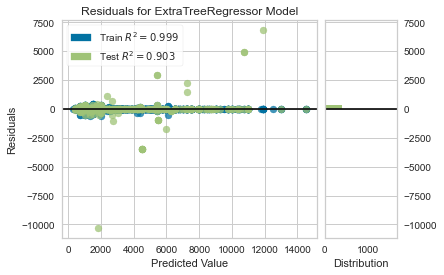

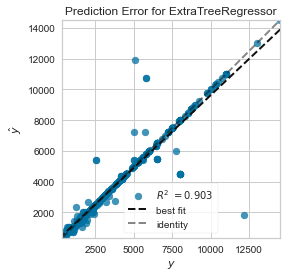

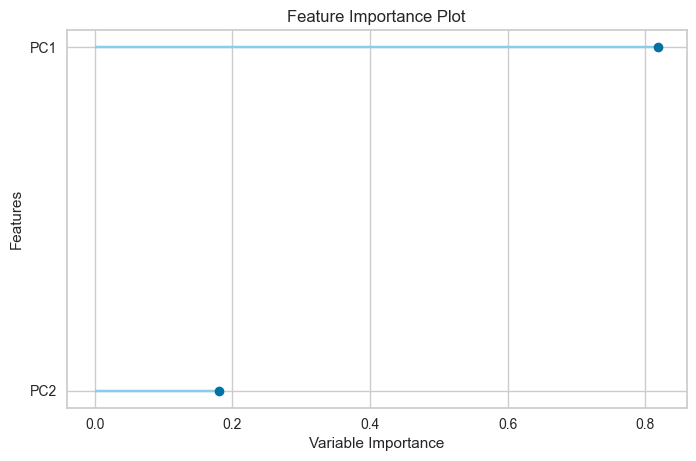

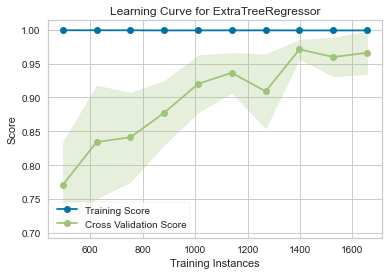

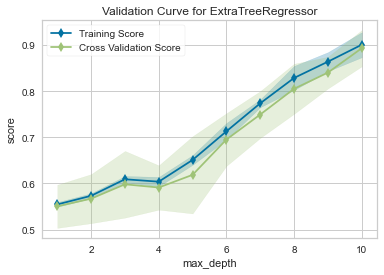

In [5]:
# Residual Plot
plot_model(best_models[0], plot='residuals')

# Prediction Error Plot
plot_model(best_models[0], plot='error')

# Feature Importance Plot
plot_model(best_models[0], plot='feature')

# Learning Curve
plot_model(best_models[0], plot='learning')

# Validation Curve
plot_model(best_models[0], plot='vc')



#best_models=compare_models()
# Plot Root Mean Squared Error (RMSE) of all models
#evaluate_model(best_models[0])










In [4]:
deploy_model(best_models[0], model_name = 'et_aws', platform = 'aws', authentication = { 'bucket'  : 'hashifbucket' })

Model Successfully Deployed on AWS S3


In [7]:
model = create_model('et')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,68.4174,43373.2019,208.2623,0.9936,0.1491,0.0552
1,50.8645,27185.2794,164.8796,0.9961,0.1288,0.0430
2,106.8551,187717.0990,433.2633,0.9694,0.1827,0.0618
3,143.1410,322216.1068,567.6408,0.9542,0.1598,0.0625
4,80.1321,116886.5398,341.8867,0.9835,0.1801,0.0693
5,68.6965,59173.1043,243.2552,0.9882,0.1311,0.0406
6,73.9072,117866.6175,343.3171,0.9838,0.1504,0.0395
7,64.9319,84263.0735,290.2810,0.9878,0.1141,0.0344
8,79.2018,136564.0867,369.5458,0.9773,0.1244,0.0422


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
create_api(model,'api')



API successfully created. This function only creates a POST API, it doesn't run it automatically. To run your API, please run this command --> !python api.py


Transformation Pipeline and Model Successfully Loaded


INFO:     Started server process [10608]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


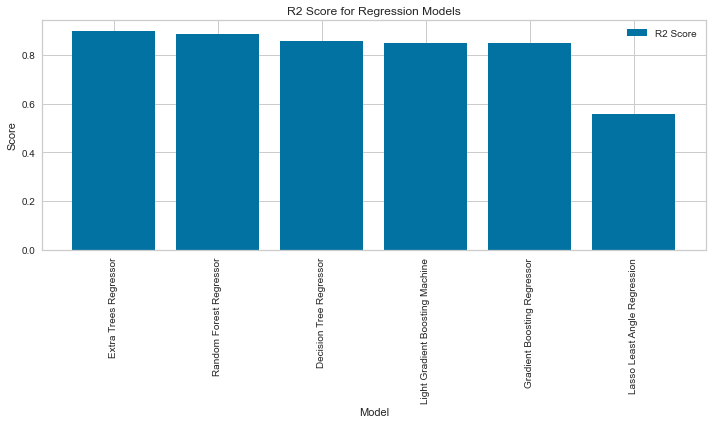

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the data as a dictionary
data = {
    'Model': ['Extra Trees Regressor', 'Random Forest Regressor', 'Decision Tree Regressor', 'Light Gradient Boosting Machine','Gradient Boosting Regressor','Lasso Least Angle Regression'],
    'R2': [0.8972, 0.8844, 0.8578, 0.8473,0.8473,0.5564]
}

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)

# Plot the R2 scores and MSE in a bar graph
plt.figure(figsize=(10, 6))
plt.bar(df['Model'], df['R2'], color='b', label='R2 Score')

# Set the labels and title
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('R2 Score for Regression Models')

# Rotate the x-axis labels for better readability
plt.xticks(rotation='vertical')

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [1]:
interpret_model(models)


NameError: name 'interpret_model' is not defined

In [26]:
#user prediction
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from pycaret.regression import load_model, predict_model

# Load the label encoders
location_encoder = LabelEncoder()
room_type_encoder = LabelEncoder()
location_encoder = joblib.load('location_encoder.joblib')
room_type_encoder = joblib.load('type_encoder.joblib')

# User input
user_location = input("Enter the location: ").strip().lower()
user_room_type = input("Enter the room type: ").strip().lower()
user_amenities = input("Enter the amenities: ").strip()

# Encode user inputs
encoded_location = location_encoder.transform([user_location])[0]
encoded_room_type = room_type_encoder.transform([user_room_type])[0]


# Preprocess amenities text
def custom_tokenizer(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)  # Perform POS tagging
    filtered_tokens = [token for token, pos in pos_tags if pos not in ['RB', 'JJ', 'VB']]  # Filter out adverbs, adjectives, and verbs
    return filtered_tokens

# Apply the same preprocessing to user amenities
user_amenities_tfidf = vectorizer.transform([user_amenities])
user_amenities_df = pd.DataFrame(user_amenities_tfidf.toarray(), columns=vectorizer.get_feature_names())

# Create a dataframe with the user inputs
user_input_df = pd.DataFrame({
    'location': [encoded_location],
    'type': [encoded_room_type]
})
user_processed = user_input_df.copy()
user_processed.columns = [re.sub('[^A-Za-z]+', '', col) for col in user_processed.columns]
user_processed = pd.concat([user_processed, user_amenities_df.iloc[:1]], axis=1)
#user_processed.drop(columns=['amenities', 'distance'], axis=1, inplace=True)
user_scaled = scaler.transform(user_processed)
user_pca = pca.transform(user_scaled)
user_pca_df = pd.DataFrame(data=user_pca, columns=['PC1', 'PC2'])
predictions = predict_model(best_models, data=user_pca_df)
predicted_price = predictions['prediction_label'].iloc[0]
print(f"Predicted price for the given input: {predicted_price}")



In [9]:
combined_df

,(,( ),( closed,),) airport,) fitness,) front,) non-smoking,) parking,) room,...,wifi air,wifi airport,wifi facilities,wifi family,wifi front,wifi non-smoking,wifi parking,wifi restaurant,wifi room,wifi rooms
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


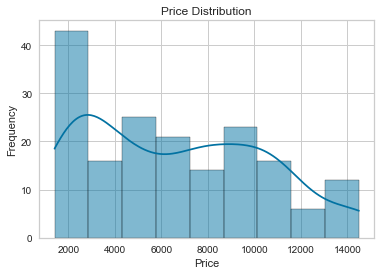

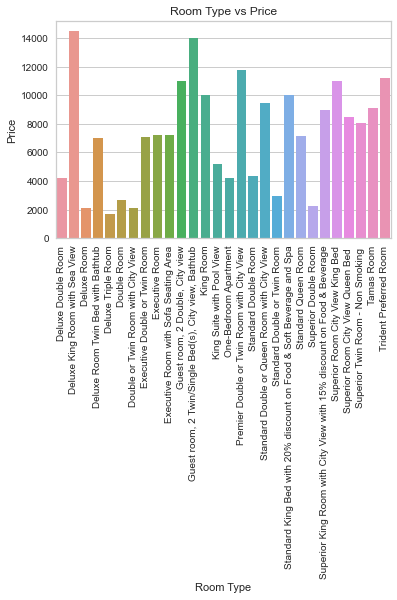

In [18]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sns

# Load the CSV data
data = pd.read_csv(f"{user_location}_{current_date}.csv")

# Calculate room type statistics
room_type_stats = data.groupby('type').agg(
    max_price=('price', 'max'),
    min_price=('price', 'min'),
    mean_price=('price', 'mean'),
    avg_reviews=('ratings', 'mean')
).reset_index()

# Create the Tkinter application
app = tk.Tk()
app.title("Hotel Dashboard")

# Create a frame for the entire page
page_frame = ttk.Frame(app, width=1280, height=720)
page_frame.pack(pady=10)

# Create a notebook for tabs
notebook = ttk.Notebook(page_frame)
notebook.pack(fill=tk.BOTH, expand=True)

# Create the first tab for Statistical Analysis
stats_tab = ttk.Frame(notebook)
notebook.add(stats_tab, text="Statistical Analysis")

# Histogram
hist_fig = plt.figure(figsize=(6, 4))
hist_plot = hist_fig.add_subplot(111)
sns.histplot(data['price'], ax=hist_plot, kde=True)
hist_plot.set_xlabel('Price')
hist_plot.set_ylabel('Frequency')
hist_plot.set_title('Price Distribution')
hist_canvas = FigureCanvasTkAgg(hist_fig, master=stats_tab)
hist_canvas.get_tk_widget().grid(row=0, column=0, sticky="nw")

# Bar graph for room types and prices
bar_fig = plt.figure(figsize=(6, 4))
bar_plot = bar_fig.add_subplot(111)
sns.barplot(x='type', y='mean_price', data=room_type_stats, ax=bar_plot)
bar_plot.set_xlabel('Room Type')
bar_plot.set_ylabel('Price')
bar_plot.set_title('Room Type vs Price')
bar_plot.set_xticklabels(room_type_stats['type'], rotation=90)
bar_canvas = FigureCanvasTkAgg(bar_fig, master=stats_tab)
bar_canvas.get_tk_widget().grid(row=0, column=1, sticky="ne")

# Room type statistics
stats_label = tk.Label(stats_tab, text="Room Type Statistics", font=("Arial", 16, "bold"))
stats_label.grid(row=1, column=0, columnspan=2, pady=10)

stats_table = ttk.Treeview(stats_tab, columns=['type', 'max_price', 'min_price', 'mean_price', 'avg_reviews'], show='headings')
stats_table.heading('type', text='Room Type')
stats_table.heading('max_price', text='Max Price')
stats_table.heading('min_price', text='Min Price')
stats_table.heading('mean_price', text='Mean Price')
stats_table.heading('avg_reviews', text='Avg Reviews')

for i in range(len(room_type_stats)):
    stats_table.insert('', 'end', values=room_type_stats.iloc[i][1:])

stats_table.grid(row=2, column=0, columnspan=2, sticky="nsew")

# Create the second tab for Model Prediction
prediction_tab = ttk.Frame(notebook)
notebook.add(prediction_tab, text="Model Prediction")

# Dropdown for Location
location_label = tk.Label(prediction_tab, text="Location:")
location_label.grid(row=0, column=0)

location_combobox = ttk.Combobox(prediction_tab, values=["Location 1", "Location 2", "Location 3"])
location_combobox.grid(row=0, column=1)

# Dropdown for Type
type_label = tk.Label(prediction_tab, text="Type:")
type_label.grid(row=1, column=0)

type_combobox = ttk.Combobox(prediction_tab, values=["Type 1", "Type 2", "Type 3"])
type_combobox.grid(row=1, column=1)

# Button for prediction
def predict():
    selected_location = location_combobox.get()
    selected_type = type_combobox.get()
    
    # Perform your prediction based on the selected_location and selected_type
    
    # Display the prediction result or update the UI accordingly

predict_button = tk.Button(prediction_tab, text="Predict", command=predict)
predict_button.grid(row=2, column=0, columnspan=2, pady=10)

# Run the Tkinter event loop
app.mainloop()







In [12]:
str='hasHif'
str=str.strip().capitalize()
str

'Hashif'

In [1]:
import os

# Step 1: Define the new folder name
new_folder_name = "new_folder"

# Step 2: Define the path to the "data" folder
data_folder_path = os.path.join(os.getcwd(), "data")

# Step 3: Create the new folder inside the "data" folder
new_folder_path = os.path.join(data_folder_path, new_folder_name)
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)

In [2]:
str='Eranakulam, cochin'
str.lower()



'eranakulam, cochin'

In [ ]:
D:\personal\projects\PriceReccomendationSystem\data